In [139]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
import joblib
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42


Load the Training and Testing Datasets 

In [140]:

try:
    train_df = pd.read_csv("train.csv")
    test_df = pd.read_csv("test.csv")
    print(" Datasets Loaded Successfully!")
except FileNotFoundError:
    print(" Error: train.csv or test.csv not found!")

print("Training Data Shape:", train_df.shape)
print("Testing Data Shape:", test_df.shape)

if 'id' in test_df.columns:
    test_ids = test_df['id']


 Datasets Loaded Successfully!
Training Data Shape: (2000, 21)
Testing Data Shape: (1000, 21)


 Data Preprocessing Fxn

In [141]:

def preprocess_data(df):
    df_processed = df.copy()
    
    # Drop irrelevant or redundant columns
    drop_cols = ['blue', 'talk_time', 'touch_screen', 'wifi']
    df_processed.drop(columns=drop_cols, inplace=True, errors='ignore')
    
    # Handle screen resolution
    df_processed['px_height'] = df_processed['px_height'].replace(0, np.nan)
    df_processed['px_width'] = df_processed['px_width'].replace(0, np.nan)
    df_processed['px_height'].fillna(df_processed['px_height'].median(), inplace=True)
    df_processed['px_width'].fillna(df_processed['px_width'].median(), inplace=True)
    df_processed['screen_megapixels'] = (df_processed['px_height'] * df_processed['px_width']) / 1_000_000
    df_processed.drop(columns=['px_height', 'px_width'], inplace=True)
    
    # Normalize RAM
    if 'ram' in df_processed.columns:
        df_processed['ram'] = (df_processed['ram'] / 1024).round(2)
    
    # Convert clock_speed into refresh_rate
    if 'clock_speed' in df_processed.columns:
        df_processed.rename(columns={'clock_speed': 'refresh_rate'}, inplace=True)
        df_processed['refresh_rate'] = 60 + (df_processed['refresh_rate'] * 15)
    
     

  
    if 'four_g' in df_processed.columns and 'three_g' in df_processed.columns:
        df_processed.rename(columns={
            'four_g': 'five_g',
            'three_g': 'four_g'
        }, inplace=True)
        
        # Ensure logical consistency: if a phone has 5G, it must also support 4G
        df_processed.loc[df_processed['five_g'] == 1, 'four_g'] = 1
    
    return df_processed

train_processed_df = preprocess_data(train_df)
test_processed_df = preprocess_data(test_df)
print(" Preprocessing Complete!")


 Preprocessing Complete!


Train-Test Split and SMOTE Visualization

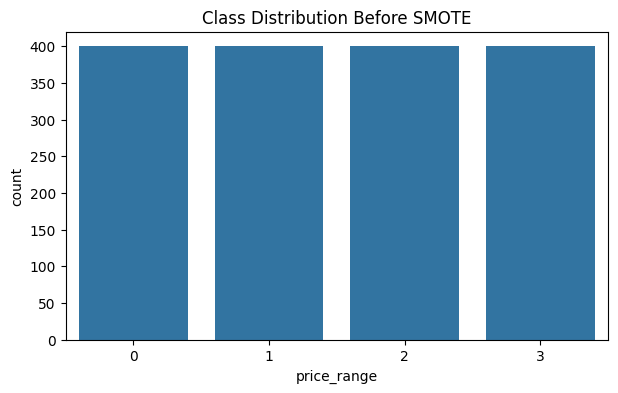

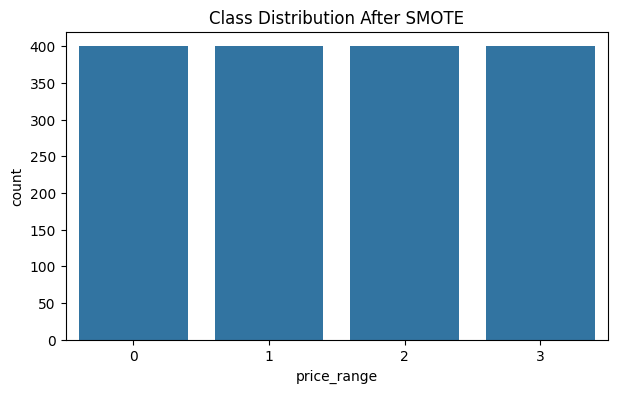

Scaling and SMOTE Balancing Complete.


In [142]:

X = train_processed_df.drop('price_range', axis=1)
y = train_processed_df['price_range']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,
                                                  random_state=RANDOM_STATE,
                                                  stratify=y)

# Before SMOTE plot
plt.figure(figsize=(7, 4))
sns.countplot(x=y_train)
plt.title("Class Distribution Before SMOTE")
plt.show()

# Apply Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Apply SMOTE
sm = SMOTE(random_state=RANDOM_STATE)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train_scaled, y_train)

# After SMOTE plot
plt.figure(figsize=(7, 4))
sns.countplot(x=y_train_resampled)
plt.title("Class Distribution After SMOTE")
plt.show()

print("Scaling and SMOTE Balancing Complete.")


Advanced EDA on Training Data Only

Running Advanced Exploratory Data Analysis...


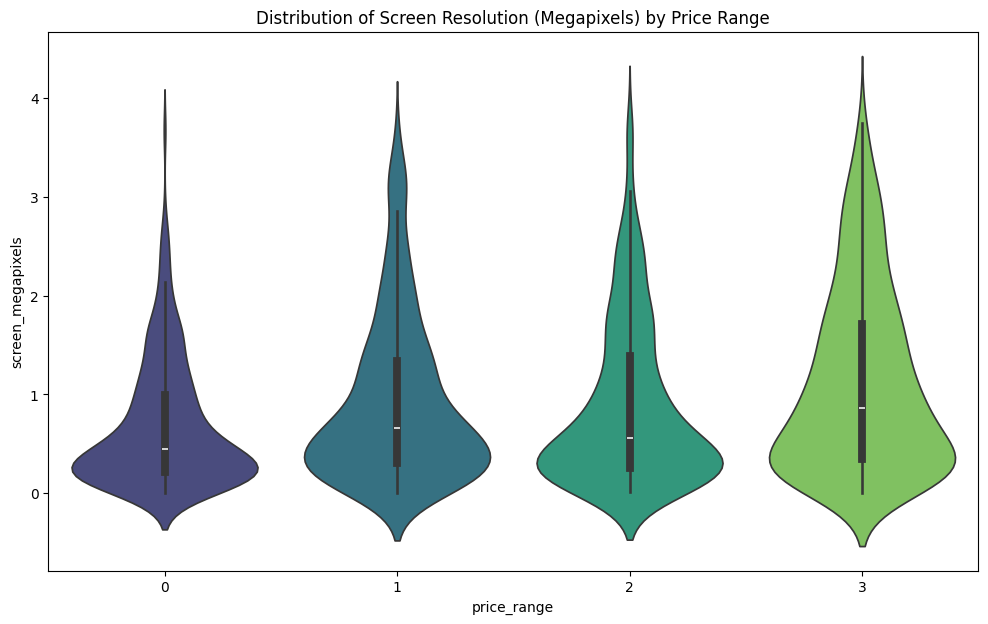

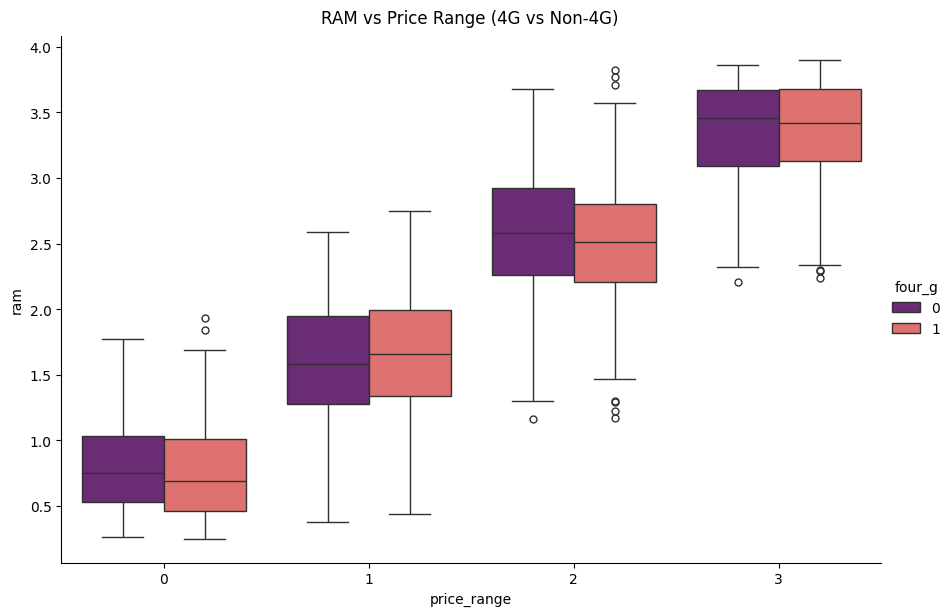

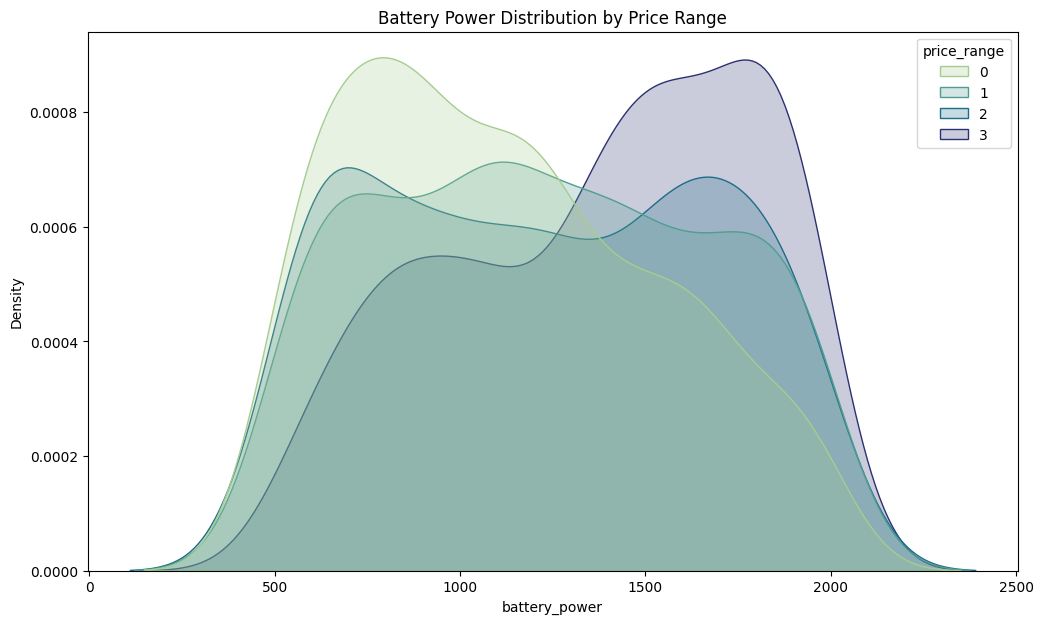

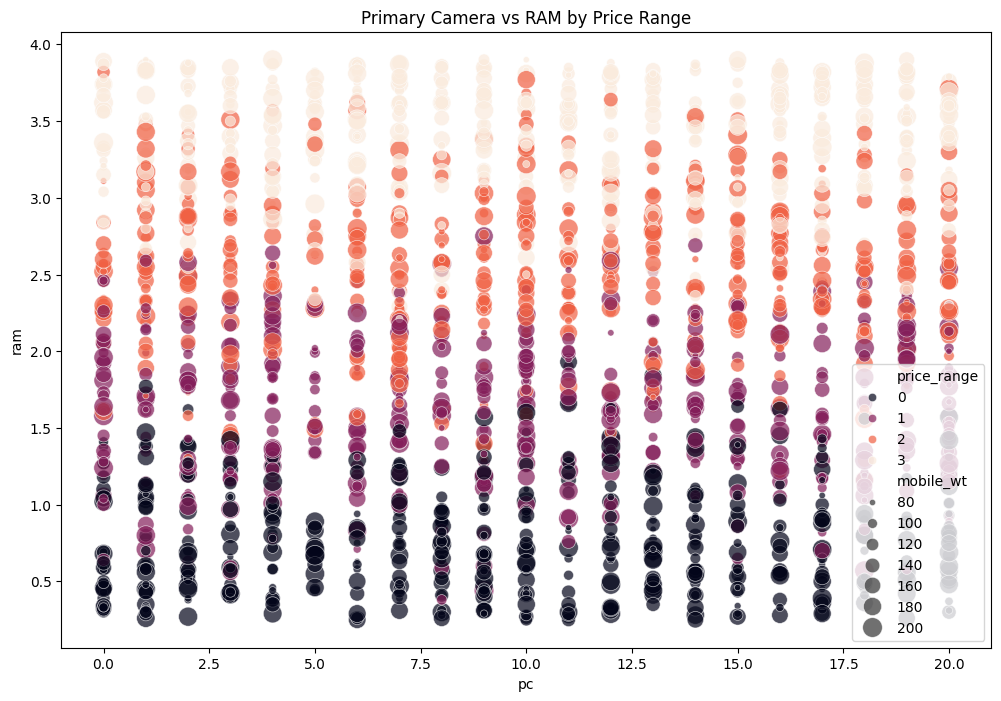

In [143]:

print("Running Advanced Exploratory Data Analysis...")

# 1. Feature Engineering Validation
plt.figure(figsize=(12, 7))
sns.violinplot(data=train_processed_df, x='price_range', y='screen_megapixels', palette='viridis')
plt.title('Distribution of Screen Resolution (Megapixels) by Price Range')
plt.show()

# 2. RAM vs Price Range by 4G
sns.catplot(data=train_processed_df, x='price_range', y='ram', hue='four_g', kind='box', palette='magma', height=6, aspect=1.5)
plt.suptitle("RAM vs Price Range (4G vs Non-4G)", y=1.02)
plt.show()

# 3. Battery Power Distribution
plt.figure(figsize=(12, 7))
sns.kdeplot(data=train_processed_df, x='battery_power', hue='price_range', fill=True, palette='crest', common_norm=False)
plt.title('Battery Power Distribution by Price Range')
plt.show()

# 4. Market Segments
plt.figure(figsize=(12, 8))
sns.scatterplot(data=train_processed_df, x='pc', y='ram', hue='price_range', size='mobile_wt', sizes=(20, 200), palette='rocket', alpha=0.7)
plt.title('Primary Camera vs RAM by Price Range')
plt.show()


Model Training & Hyperparameter Tuning

In [144]:

# Define the modelsg
models = {
    'Logistic Regression': LogisticRegression(random_state=RANDOM_STATE, max_iter=2000),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'Random Forest': RandomForestClassifier(random_state=RANDOM_STATE),
    'SVM': SVC(random_state=RANDOM_STATE, probability=True),
    'Naive Bayes': GaussianNB(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=RANDOM_STATE)
}

param_grids = {
    'Logistic Regression': {'C': [0.1, 1, 10], 'solver': ['liblinear', 'lbfgs']},
    'KNN': {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']},
    'Decision Tree': {'max_depth': [5, 10, 15, None], 'criterion': ['gini', 'entropy']},
    'Random Forest': {'n_estimators': [100, 200, 300], 'max_depth': [5, 10, 15]},
    'SVM': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
    'Naive Bayes': {},  # No parameters to tune
    'XGBoost': {'n_estimators': [100, 200], 'max_depth': [3, 5, 7], 'learning_rate': [0.05, 0.1]}
}

# This list will store all results for final comparison
tuning_results = []
# This dictionary will store the best version of each tuned model
tuned_models = {}

print("--- 🚀 Starting Model Training & Tuning ---")

for name, model in models.items():
    print(f"\n>> Processing: {name}")

    # --- 1. Accuracy Before Tuning ---
    model.fit(X_train_resampled, y_train_resampled)
    before_preds = model.predict(X_val_scaled)
    before_accuracy = accuracy_score(y_val, before_preds)
    print(f"  Accuracy Before Tuning: {before_accuracy:.4f}")
    
    # --- 2. Hyperparameter Tuning ---
    if param_grids[name]:
        grid_search = GridSearchCV(model, param_grids[name], cv=3, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train_resampled, y_train_resampled)
        best_estimator = grid_search.best_estimator_
        best_params = grid_search.best_params_
        print(f"  Best Parameters found: {best_params}")
    else: # For models with no tuning grid, like Naive Bayes
        best_estimator = model
        best_params = "N/A"
        
    tuned_models[name] = best_estimator # Save the tuned model
    
    # --- 3. Accuracy After Tuning (on Validation set) ---
    after_preds = best_estimator.predict(X_val_scaled)
    after_accuracy = accuracy_score(y_val, after_preds)
    print(f"  ✅ Accuracy After Tuning: {after_accuracy:.4f}")
    
    # --- 4. Training Accuracy (of the tuned model) for overfitting check ---
    train_preds = best_estimator.predict(X_train_resampled)
    train_accuracy = accuracy_score(y_train_resampled, train_preds)

    # Store all metrics together for this model
    tuning_results.append({
        'Model': name,
        'Train Accuracy (Tuned)': train_accuracy,
        'Validation Accuracy (Before)': before_accuracy,
        'Validation Accuracy (Tuned)': after_accuracy,
        'Best Params': best_params
    })

# Create a final comparison DataFrame from the collected results
comparison_df = pd.DataFrame(tuning_results).sort_values(by='Validation Accuracy (Tuned)', ascending=False)

--- 🚀 Starting Model Training & Tuning ---

>> Processing: Logistic Regression
  Accuracy Before Tuning: 0.9425
  Best Parameters found: {'C': 10, 'solver': 'lbfgs'}
  ✅ Accuracy After Tuning: 0.9450

>> Processing: KNN
  Accuracy Before Tuning: 0.5275
  Best Parameters found: {'C': 10, 'solver': 'lbfgs'}
  ✅ Accuracy After Tuning: 0.9450

>> Processing: KNN
  Accuracy Before Tuning: 0.5275
  Best Parameters found: {'n_neighbors': 9, 'weights': 'distance'}
  ✅ Accuracy After Tuning: 0.5725

>> Processing: Decision Tree
  Accuracy Before Tuning: 0.8400
  Best Parameters found: {'n_neighbors': 9, 'weights': 'distance'}
  ✅ Accuracy After Tuning: 0.5725

>> Processing: Decision Tree
  Accuracy Before Tuning: 0.8400
  Best Parameters found: {'criterion': 'entropy', 'max_depth': 15}
  ✅ Accuracy After Tuning: 0.8500

>> Processing: Random Forest
  Best Parameters found: {'criterion': 'entropy', 'max_depth': 15}
  ✅ Accuracy After Tuning: 0.8500

>> Processing: Random Forest
  Accuracy Befor

Visualize Results & Select Best Model



 Final Tuning Summary 


,Model,Validation Accuracy (Before),Validation Accuracy (Tuned),Train Accuracy (Tuned)
1,KNN,0.5275,0.5725,1.000000
5,Naive Bayes,0.7975,0.7975,0.813750
2,Decision Tree,0.8400,0.8500,1.000000
3,Random Forest,0.8800,0.8775,0.997500
6,XGBoost,0.9175,0.9175,0.976250
4,SVM,0.8900,0.9400,0.945625
0,Logistic Regression,0.9425,0.9450,0.948750


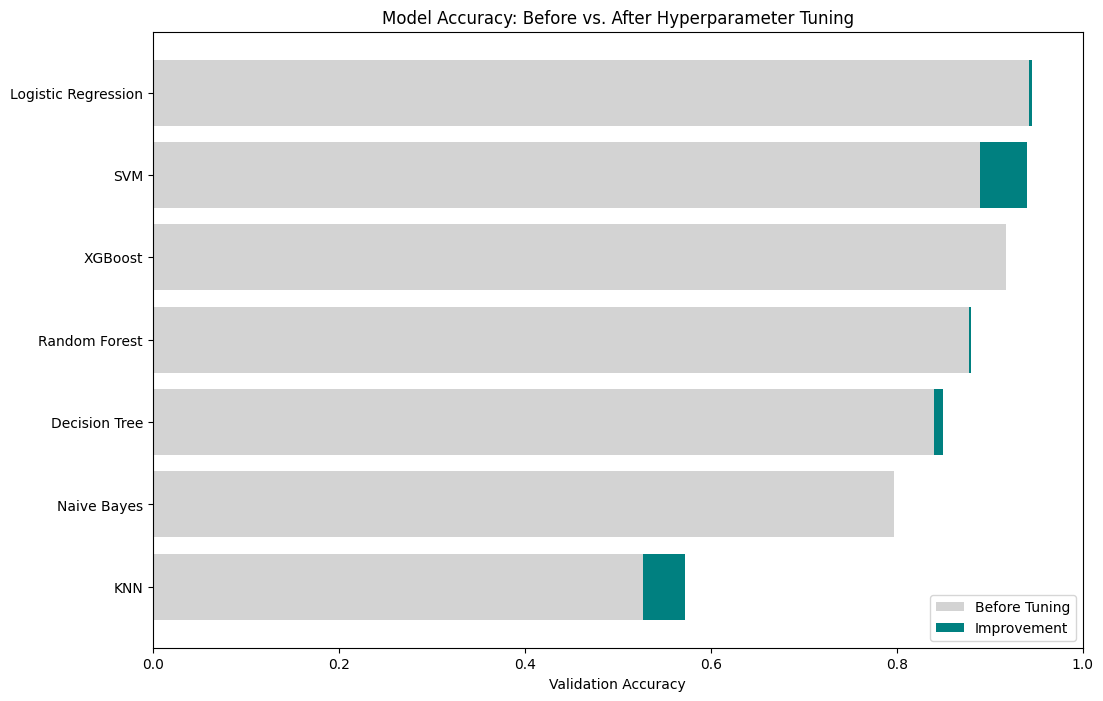

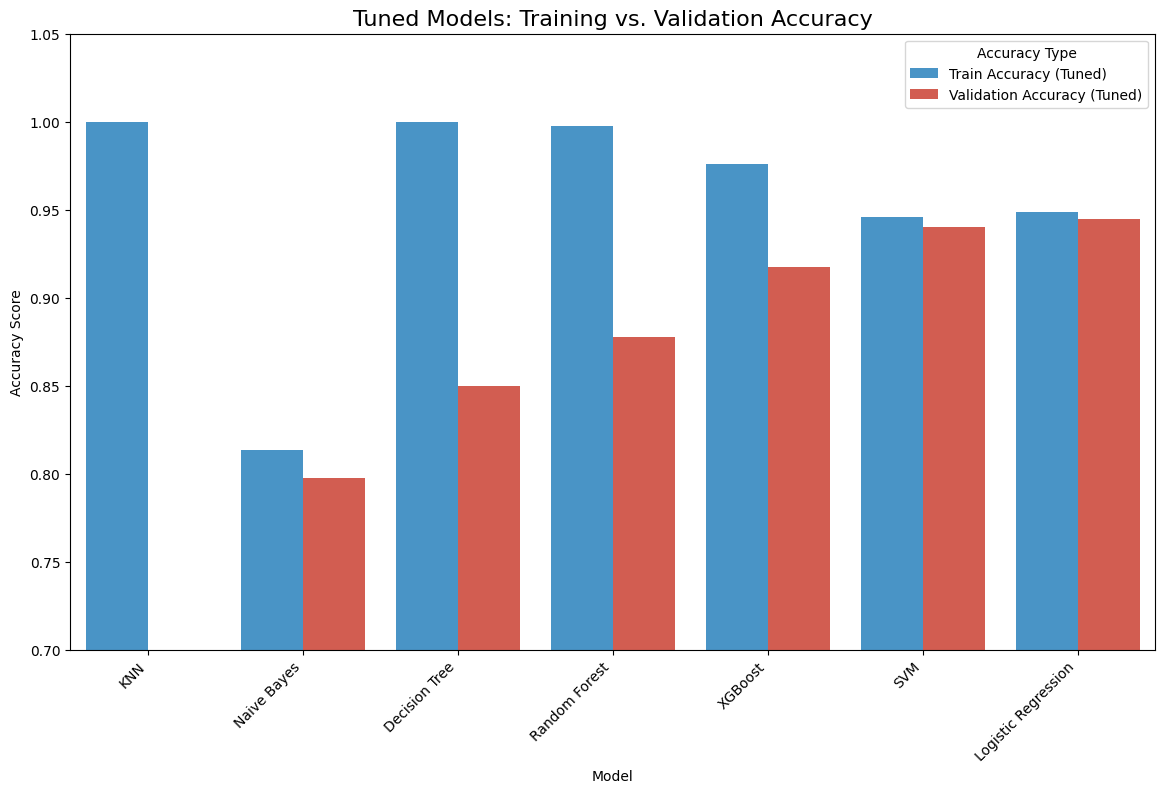


Best Model Selected (based on highest Validation Accuracy): Logistic Regression


In [146]:


print("\n\n Final Tuning Summary ")
display(comparison_df[['Model', 'Validation Accuracy (Before)', 'Validation Accuracy (Tuned)', 'Train Accuracy (Tuned)']])

#  Before vs. After Tuning Comparison 
comparison_df.sort_values('Validation Accuracy (Tuned)', inplace=True)
plt.figure(figsize=(12, 8))
plt.barh(comparison_df['Model'], comparison_df['Validation Accuracy (Before)'], color='lightgray', label='Before Tuning')
plt.barh(comparison_df['Model'], comparison_df['Validation Accuracy (Tuned)'] - comparison_df['Validation Accuracy (Before)'],
         left=comparison_df['Validation Accuracy (Before)'], color='teal', label='Improvement')
plt.xlabel("Validation Accuracy")
plt.title("Model Accuracy: Before vs. After Hyperparameter Tuning")
plt.legend()
plt.xlim(0, 1.0)
plt.show()

#  Train vs. Validation Accuracy (to check for overfitting) 
comparison_melted = comparison_df.melt(id_vars='Model', 
                                       value_vars=['Train Accuracy (Tuned)', 'Validation Accuracy (Tuned)'],
                                       var_name='Accuracy Type', 
                                       value_name='Accuracy Score')
plt.figure(figsize=(14, 8))
sns.barplot(data=comparison_melted, x='Model', y='Accuracy Score', hue='Accuracy Type', palette=['#3498db', '#e74c3c'])
plt.title('Tuned Models: Training vs. Validation Accuracy', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Accuracy Score")
plt.ylim(0.7, 1.05)
plt.show()

best_model_name = comparison_df.sort_values(by='Validation Accuracy (Tuned)', ascending=False).iloc[0]['Model']
best_model = tuned_models[best_model_name]
print(f"\nBest Model Selected (based on highest Validation Accuracy): {best_model_name}")

Save Model

In [148]:

joblib.dump(best_model, "mobile_price_model.pkl")
joblib.dump(scaler, "mobile_price_scaler.pkl")
print(f" Best model ({best_model_name}) and scaler saved successfully!")

# Prepare Test Data for Final Prediction 
if 'id' in test_processed_df.columns:
    X_test_final = test_processed_df.drop('id', axis=1)
else:
    X_test_final = test_processed_df


X_test_final = X_test_final.reindex(columns=X.columns, fill_value=0)


X_test_final_scaled = scaler.transform(X_test_final)


final_predictions = best_model.predict(X_test_final_scaled)


submission_df = pd.DataFrame({'id': test_ids, 'price_range': final_predictions})
submission_df.to_csv("submission.csv", index=False)

print("\n Submission file 'submission.csv' created successfully!")
print("Top 5 predictions:")
display(submission_df.head())

 Best model (Logistic Regression) and scaler saved successfully!

 Submission file 'submission.csv' created successfully!
Top 5 predictions:


,id,price_range
0,1,2
1,2,3
2,3,2
3,4,3
4,5,1
